In [537]:
# 그래프 한글깨짐 보완
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy import stats
from statsmodels.formula.api import ols

import statsmodels.api as sm
import statsmodels.formula.api as smf

# 경고문 제거
import warnings 
warnings.filterwarnings('ignore')

# - 부호 깨짐 해결
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

In [538]:
train = pd.read_csv('C:/Users/admin/Desktop/개인프로젝트/data/train_weather.csv')

In [539]:
train = train.drop('Unnamed: 0', axis = 1)

In [540]:
train.columns = ['date', 'week', 'mem_tot', 'mem_va', 'mem_bt', 'mem_ot', 'mem_hj', 'breakfast', 'lunch', 'dinner', 'lunch_num', 'dinner_num', 'lunch_tem', 'lunch_rain', 'lunch_snow', 'dinner_tem', 'dinner_rain','dinner_snow', 'mem_poss']

In [541]:
train['month'] = pd.Series()
train['day'] = pd.Series()
for i in range(train['date'].size):
    train['month'][i] = train['date'][i][5:7]
    train['day'][i] = train['date'][i][8:]

In [542]:
sum(train['lunch_snow'].isna())

1204

In [543]:
sum(train['dinner_snow'].isna())

1205

## **적설량은 제외**

In [544]:
train = train.drop(['lunch_snow', 'dinner_snow'],axis = 1)

In [545]:
# 기온누락 전날기온으로 대체
train['lunch_tem'][659] = train['lunch_tem'][658]

In [546]:
sum(train['lunch_rain'].isna())

1062

In [547]:
sum(train['dinner_rain'].isna())

1059

In [548]:
## 석식메뉴가 없는 날 중 석식계가 있는 날 발견
c = 0
for i in range(len(train)):
    if len(train['dinner'][i]) < 28:
        c = c+1
        print(train['dinner'][i],c,'번째', train['dinner_num'][i], i)

    *         1 번째 0.0 204
    *         2 번째 0.0 224
     *        3 번째 0.0 244
    *         4 번째 0.0 262
    *         5 번째 0.0 281
    *         6 번째 0.0 306
      자기계발의날       7 번째 0.0 327
      *자기계발의날*       8 번째 0.0 346
      가정의날       9 번째 0.0 366
    *         10 번째 0.0 392
    *         11 번째 0.0 412
    *         12 번째 0.0 424
    *         13 번째 0.0 449
    *         14 번째 0.0 468
    *         15 번째 0.0 492
    *         16 번째 0.0 510
      *       17 번째 0.0 529
             18 번째 0.0 549
             19 번째 0.0 571
      *       20 번째 448.0 586
     *        21 번째 0.0 589
             22 번째 0.0 609
    *         23 번째 0.0 633
             24 번째 0.0 648
    자기계발의날         25 번째 0.0 667
    *         26 번째 0.0 687
    자기계발의날         27 번째 0.0 706
    자기개발의날         28 번째 0.0 730
    *  자기계발의날  *     29 번째 0.0 747
    *  자기개발의날  *     30 번째 0.0 766
    *  자기계발의날  *     31 번째 0.0 786
    *  자기개발의날  *     32 번째 0.0 809
   *  자기개발의날  *      33 번째 0.0 828
    자기계발의날         34 

In [549]:
# 오기입이라 판단하여 0으로 처리
train['dinner_num'][586] = 0

In [550]:
# 강수량누락 0으로 대체
train_rain0 = train.fillna(0)

In [551]:
## 메뉴데이터 제거
train_rain0 = train_rain0.drop(['breakfast','lunch','dinner'], axis=1)

# ================  필수

In [552]:
train = train_rain0.loc[train_rain0['dinner_num'] != 0] # dinner_num이 0이 아닌것 자기계발의 날떄문에

In [553]:
train.head(1)

,date,week,mem_tot,mem_va,mem_bt,mem_ot,mem_hj,lunch_num,dinner_num,lunch_tem,lunch_rain,dinner_tem,dinner_rain,mem_poss,month,day
0,2016-02-01,월,2601.0,50.0,150.0,238.0,0.0,1039.0,331.0,3.0,0.0,0.9,0.0,2401.0,2.0,1.0


# **휴일관련 변수 생성**

In [554]:
# 휴일 전날(금요일 포함)
before_holi = ['2016-02-29','2016-04-12','2016-05-04','2016-09-13','2017-01-02','2017-01-26','2017-02-28','2017-05-02','2017-05-04','2017-05-08','2017-06-05','2018-05-21','2018-06-05','2018-06-12','2018-08-14','2018-10-08','2018-12-24','2019-02-28','2019-06-05','2019-08-14','2019-09-11','2019-10-02','2019-10-08','2019-12-24','2020-01-23','2020-04-14','2020-04-29','2020-05-04','2020-10-08','2020-12-24']

In [555]:
# 휴일 다음날(월요일 포함)
after_holi = ['2016-02-11','2016-03-02','2016-04-14','2016-06-07','2016-08-16','2016-10-04','2016-12-26','2017-01-31','2017-03-02','2017-05-04','2017-05-10','2017-06-07','2017-08-16','2017-10-10','2017-12-26','2018-01-02','2018-03-02','2018-05-08','2018-05-23','2018-06-07','2018-06-14','2018-08-16','2018-09-27','2018-10-04','2018-10-10','2018-12-26','2019-01-02','2019-02-07','2019-05-07','2019-06-07','2019-08-16','2019-10-04','2019-10-10','2019-12-26','2020-01-02','2020-01-28','2020-04-16','2020-05-01','2020-05-06','2020-08-18']

In [556]:
# 여름 휴가 07/27 ~ 08/17
summer_va = ['2016-07-27',
'2016-07-28',
'2016-07-29',
'2016-08-01',
'2016-08-02',
'2016-08-03',
'2016-08-04',
'2016-08-05',
'2016-08-08',
'2016-08-09',
'2016-08-10',
'2016-08-11',
'2016-08-12',
'2016-08-16',
'2016-08-17',
'2017-07-27',
'2017-07-28',
'2017-07-31',
'2017-08-01',
'2017-08-02',
'2017-08-03',
'2017-08-04',
'2017-08-07',
'2017-08-08',
'2017-08-09',
'2017-08-10',
'2017-08-11',
'2017-08-14',
'2017-08-16',
'2017-08-17',
'2018-07-27',
'2018-07-30',
'2018-07-31',
'2018-08-01',
'2018-08-02',
'2018-08-03',
'2018-08-06',
'2018-08-07',
'2018-08-08',
'2018-08-09',
'2018-08-10',
'2018-08-13',
'2018-08-14',
'2018-08-16',
'2018-08-17',
'2019-07-29',
'2019-07-30',
'2019-07-31',
'2019-08-01',
'2019-08-02',
'2019-08-05',
'2019-08-06',
'2019-08-07',
'2019-08-08',
'2019-08-09',
'2019-08-12',
'2019-08-13',
'2019-08-14',
'2019-08-16',
'2020-07-27',
'2020-07-28',
'2020-07-29',
'2020-07-30',
'2020-07-31',
'2020-08-03',
'2020-08-04',
'2020-08-05',
'2020-08-06',
'2020-08-07',
'2020-08-10',
'2020-08-11',
'2020-08-12',
'2020-08-13',
'2020-08-14'
]

In [557]:
# 연말 12/22 ~ 12/31
end_year = [
'2016-12-22',
'2016-12-23',
'2016-12-26',
'2016-12-27',
'2016-12-28',
'2016-12-29',
'2016-12-30',
'2017-12-22',
'2017-12-26',
'2017-12-27',
'2017-12-28',
'2017-12-29',
'2018-12-24',
'2018-12-26',
'2018-12-27',
'2018-12-28',
'2018-12-31',
'2019-12-23',
'2019-12-24',
'2019-12-26',
'2019-12-27',
'2019-12-30',
'2019-12-31',
'2020-12-22',
'2020-12-23',
'2020-12-24',
'2020-12-28',
'2020-12-29',
'2020-12-30',
'2020-12-31'
]

In [558]:
# 휴일전날
holi_be = pd.DataFrame(before_holi)
holi_be['holi_be'] = 1
holi_be.columns = ['date','holi_be']
train = pd.merge(train, holi_be, on = 'date',how = 'outer').dropna(thresh = 9)

In [559]:
# 휴일 다음날
holi_af = pd.DataFrame(after_holi)
holi_af['holi_af'] = 1
holi_af.columns = ['date','holi_af']
train = pd.merge(train, holi_af, on = 'date',how = 'outer').dropna(thresh = 9)

In [560]:
# 여름휴가
summer = pd.DataFrame(summer_va)
summer['summer1'] = 1
summer.columns = ['date','summer1']
train = pd.merge(train, summer, on = 'date', how = 'outer').dropna(thresh = 9)

In [561]:
# 연말
year_end = pd.DataFrame(end_year)
year_end['year_end'] = 1
year_end.columns = ['date','year_end']
train = pd.merge(train, year_end, on = 'date', how = 'outer').dropna(thresh = 9)

In [562]:
# 휴일 다음날 (월요일포함)
train.loc[(train['week'] == '월'), 'holi_af'] = 1

In [563]:
# 휴일 전날 (금요일포함)
train.loc[(train['week'] == '금'), 'holi_be'] = 1

In [564]:
# NaN --> 0으로 대체
train = train.fillna(0)

In [565]:
train.head(1)

,date,week,mem_tot,mem_va,mem_bt,mem_ot,mem_hj,lunch_num,dinner_num,lunch_tem,lunch_rain,dinner_tem,dinner_rain,mem_poss,month,day,holi_be,holi_af,summer1,year_end
0,2016-02-01,월,2601.0,50.0,150.0,238.0,0.0,1039.0,331.0,3.0,0.0,0.9,0.0,2401.0,2.0,1.0,0.0,1.0,0.0,0.0


In [566]:
train.head()

,date,week,mem_tot,mem_va,mem_bt,mem_ot,mem_hj,lunch_num,dinner_num,lunch_tem,lunch_rain,dinner_tem,dinner_rain,mem_poss,month,day,holi_be,holi_af,summer1,year_end
0,2016-02-01,월,2601.0,50.0,150.0,238.0,0.0,1039.0,331.0,3.0,0.0,0.9,0.0,2401.0,2.0,1.0,0.0,1.0,0.0,0.0
1,2016-02-02,화,2601.0,50.0,173.0,319.0,0.0,867.0,560.0,1.7,0.0,2.4,0.0,2378.0,2.0,2.0,0.0,0.0,0.0,0.0
2,2016-02-03,수,2601.0,56.0,180.0,111.0,0.0,1017.0,573.0,3.2,0.0,3.0,0.0,2365.0,2.0,3.0,0.0,0.0,0.0,0.0
3,2016-02-04,목,2601.0,104.0,220.0,355.0,0.0,978.0,525.0,3.7,0.0,4.0,0.0,2277.0,2.0,4.0,0.0,0.0,0.0,0.0
4,2016-02-05,금,2601.0,278.0,181.0,34.0,0.0,925.0,330.0,6.3,0.0,5.7,0.0,2142.0,2.0,5.0,1.0,0.0,0.0,0.0


# ================================= **데이터프레임**

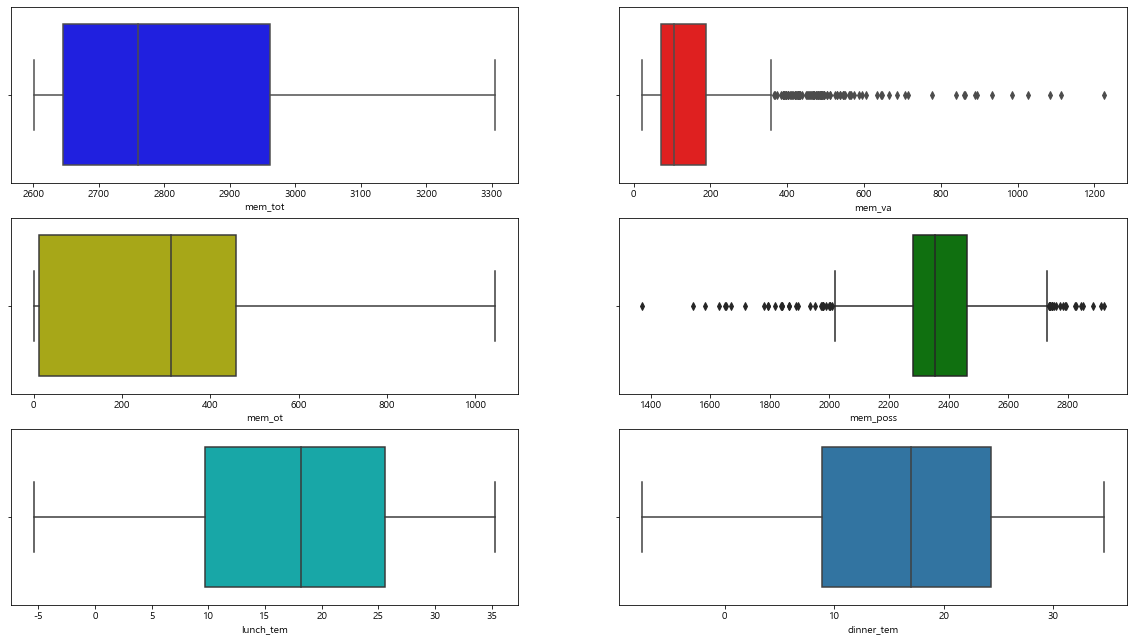

In [567]:
## boxplot

figure, ((ax1, ax2) ,(ax3, ax4), (ax5, ax6)) = plt.subplots(nrows = 3, ncols = 2)
figure.set_size_inches(20, 11)

sns.boxplot(x = 'mem_tot', data = train, ax = ax1, color = 'B')
sns.boxplot(x = 'mem_va', data = train, ax = ax2, color = 'R')
sns.boxplot(x = 'mem_ot', data = train, ax = ax3, color = 'Y')
sns.boxplot(x = 'mem_poss', data = train, ax = ax4, color = 'G')
sns.boxplot(x = 'lunch_tem', data = train, ax = ax5, color = 'C')
sns.boxplot(x = 'dinner_tem', data = train, ax = ax6)

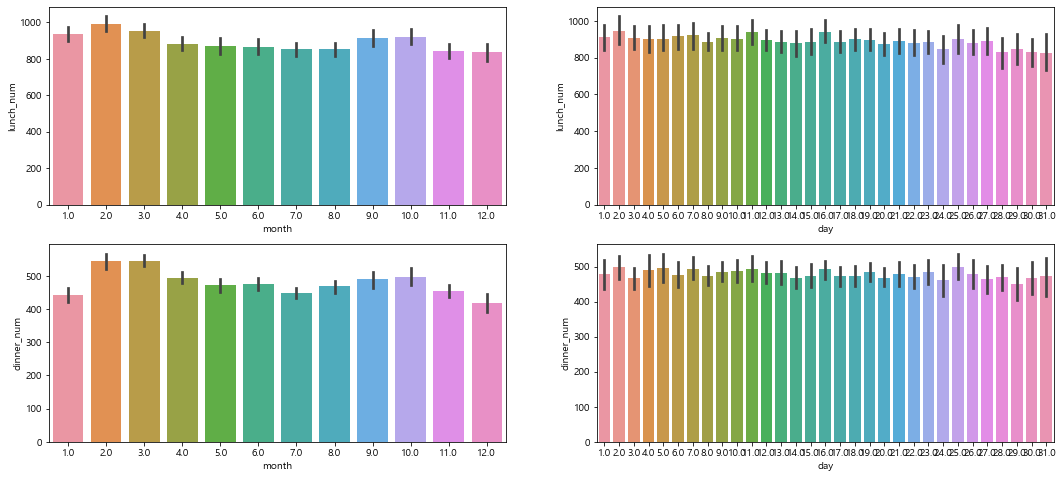

In [568]:
## barplot

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2)
figure.set_size_inches(18,8)

sns.barplot(x = 'month', y = 'lunch_num', data = train, ax = ax1)
sns.barplot(x = 'day', y = 'lunch_num', data = train, ax = ax2)
sns.barplot(x = 'month', y = 'dinner_num', data = train, ax = ax3)
sns.barplot(x = 'day', y = 'dinner_num', data = train, ax = ax4)

In [569]:
train.columns

Index(['date', 'week', 'mem_tot', 'mem_va', 'mem_bt', 'mem_ot', 'mem_hj',
       'lunch_num', 'dinner_num', 'lunch_tem', 'lunch_rain', 'dinner_tem',
       'dinner_rain', 'mem_poss', 'month', 'day', 'holi_be', 'holi_af',
       'summer1', 'year_end'],
      dtype='object')

In [570]:
corr = train.iloc[:,[14,15,2,3,4,5,6,9,10,11,12,13,18,19,20,21,7,8]].corr()

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (15, 11))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, center = 0,
           square = True, linewidths = 0.5, cbar_kws = {'shrink' : 0.5}, annot = True)

IndexError: positional indexers are out-of-bounds

# ======================================  
# **가설 1번 강수 여부에 따라 식수인원에 차이가 있다**  
# **-완**
### **점심에 비 여부에 따라 식수인원 차이 검정**

In [ ]:
# 점심에 비가온날
yeslunch_rain = train.loc[train['lunch_rain'] != 0]
# 점심에 비가오지않은날
nolunch_rain = train.loc[train['lunch_rain'] == 0]

In [ ]:
fig1, ax1 = plt.subplots(nrows = 1, ncols = 1 , figsize = (8,5))
ax1.boxplot([yeslunch_rain['lunch_num'], nolunch_rain['lunch_num']])
ax1.set_xticklabels(['lunch_rain_yes','lunch_rain_no'])

In [ ]:
# 귀무가설 : 두집단 분포 동일하다
stats.levene(yeslunch_rain['lunch_num'],nolunch_rain['lunch_num'])

In [ ]:
ttest_ind(yeslunch_rain['lunch_num'], nolunch_rain['lunch_num'], equal_var=True)

#### **점심에 강수여부에 따라 점심 식수인원에 유의미한 차이가 있다**

### **저녁에 비 여부에 따라 식수인원 차이 검정**

In [ ]:
# 저녁에 비가온날
yesdinner_rain = train.loc[train['dinner_rain'] != 0]
# 저녁에 비가오지않은날
nodinner_rain = train.loc[train['dinner_rain'] == 0]

In [ ]:
fig2, ax2 = plt.subplots(nrows = 1, ncols = 1 , figsize = (8,5))
ax2.boxplot([yesdinner_rain['dinner_num'], nodinner_rain['dinner_num']])
ax2.set_xticklabels(['dinner_rain_yes','dinner_rain_no'])

In [ ]:
stats.levene(yesdinner_rain['dinner_num'],nodinner_rain['dinner_num'])

In [571]:
ttest_ind(yesdinner_rain['dinner_num'], nodinner_rain['dinner_num'], equal_var=True)

Ttest_indResult(statistic=0.24314469394312666, pvalue=0.8079363339956721)

#### **저녁에 강수여부에 따라 저녁 식수인원에 유의미한 차이가 없다.**

# ==============================================  
# **가설 2번  온도에 따라 식수인원에 차이가 있다**  
# **-완**

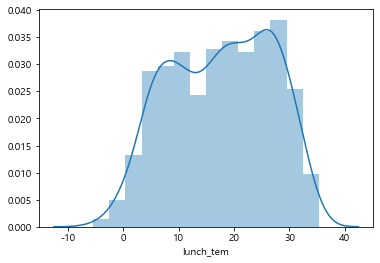

In [572]:
sns.distplot(train['lunch_tem'])

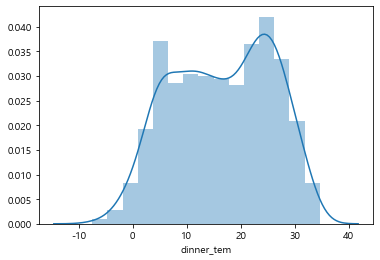

In [573]:
sns.distplot(train['dinner_tem'])

## **점심 온도에 따른 식수인원 차이 검정**

In [574]:
train.lunch_tem.describe()

count    1161.000000
mean       17.635659
std         9.173468
min        -5.400000
25%         9.700000
50%        18.200000
75%        25.600000
max        35.300000
Name: lunch_tem, dtype: float64

In [575]:
train_l_l = train[train['lunch_tem'] <= 9.7]
train_m_l = train[(train['lunch_tem'] > 9.7) & (train['lunch_tem'] <= 25.6)]
train_h_l = train[train['lunch_tem'] > 25.6]

[Text(0, 0, 'lunch_tem_low'),
 Text(0, 0, 'lunch_tem_mid'),
 Text(0, 0, 'lunch_tem_high')]

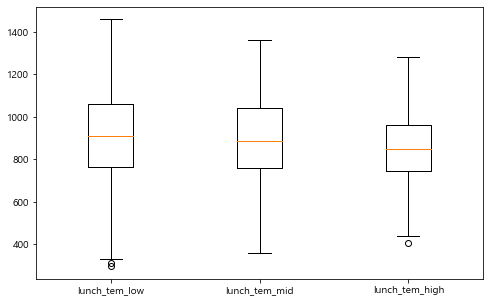

In [576]:
fig3, ax3 = plt.subplots(nrows = 1, ncols = 1 , figsize = (8,5))
ax3.boxplot([train_l_l['lunch_num'], train_m_l['lunch_num'], train_h_l['lunch_num']])
ax3.set_xticklabels(['lunch_tem_low','lunch_tem_mid','lunch_tem_high'])

In [577]:
tem_l_df = [train_l_l, train_m_l, train_h_l]
tem_l_tx = ['train_l_l', 'train_m_l', 'train_h_l']
print('=' * 40)
for i in range(3):
    print(tem_l_tx[i])
    for j in range(3):
        _, pval = stats.levene(tem_l_df[i]['lunch_num'], tem_l_df[j]['lunch_num'])
        if pval > 0.05:
            _2, pval_t = ttest_ind(tem_l_df[i]['lunch_num'], tem_l_df[j]['lunch_num'], equal_var = True)
            print(pval_t,'    vs', tem_l_tx[j])
        else :
            _2, pval_t = ttest_ind(tem_l_df[i]['lunch_num'], tem_l_df[j]['lunch_num'], equal_var = False)
            print(pval_t,'    vs', tem_l_tx[j])
    print('=' * 40)

train_l_l
1.0     vs train_l_l
0.1763692267566472     vs train_m_l
0.0007144996006216482     vs train_h_l
train_m_l
0.1763692267566472     vs train_l_l
1.0     vs train_m_l
0.008433089107484708     vs train_h_l
train_h_l
0.0007144996006216482     vs train_l_l
0.008433089107484708     vs train_m_l
1.0     vs train_h_l


## **저녁 온도에 따른 식수인원 차이 검정**

In [578]:
train.dinner_tem.describe()

count    1161.000000
mean       16.529027
std         9.198115
min        -7.500000
25%         8.900000
50%        17.000000
75%        24.300000
max        34.600000
Name: dinner_tem, dtype: float64

In [579]:
train_l_d = train[train['dinner_tem'] <= 8.9]
train_m_d = train[(train['dinner_tem'] > 8.9) & (train['dinner_tem'] <= 24.3)]
train_h_d = train[train['dinner_tem'] > 24.3]

[Text(0, 0, 'dinner_tem_low'),
 Text(0, 0, 'dinner_tem_mid'),
 Text(0, 0, 'dinner_tem_high')]

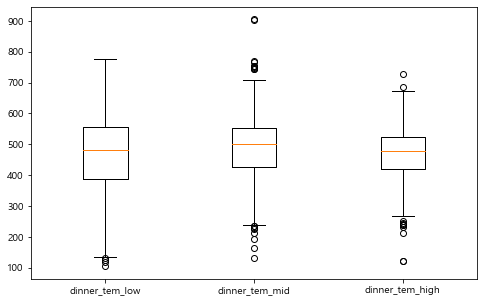

In [580]:
fig4, ax4 = plt.subplots(nrows = 1, ncols = 1 , figsize = (8,5))
ax4.boxplot([train_l_d['dinner_num'], train_m_d['dinner_num'], train_h_d['dinner_num']])
ax4.set_xticklabels(['dinner_tem_low','dinner_tem_mid','dinner_tem_high'])

In [581]:
tem_d_df = [train_l_d, train_m_d, train_h_d]
tem_d_tx = ['train_l_d', 'train_m_d', 'train_h_d']
print('=' * 40)
for i in range(3):
    print(tem_d_tx[i])
    for j in range(3):
        _, pval = stats.levene(tem_d_df[i]['dinner_num'], tem_d_df[j]['dinner_num'])
        if pval > 0.05:
            _2, pval_t = ttest_ind(tem_d_df[i]['dinner_num'], tem_d_df[j]['dinner_num'], equal_var = True)
            print(pval_t,'    vs', tem_d_tx[j])
        else :
            _2, pval_t = ttest_ind(tem_d_df[i]['dinner_num'], tem_d_df[j]['dinner_num'], equal_var = False)
            print(pval_t,'    vs', tem_d_tx[j])
    print('=' * 40)

train_l_d
1.0     vs train_l_d
0.016707412975336112     vs train_m_d
0.935898712766036     vs train_h_d
train_m_d
0.016707412975336112     vs train_l_d
1.0     vs train_m_d
0.001999427890081429     vs train_h_d
train_h_d
0.935898712766036     vs train_l_d
0.001999427890081429     vs train_m_d
1.0     vs train_h_d


# ===================================  
# **가설 3번 요일에 따라 식수인원에 차이가 있다**  
# **-완**

## **점심식수인원**

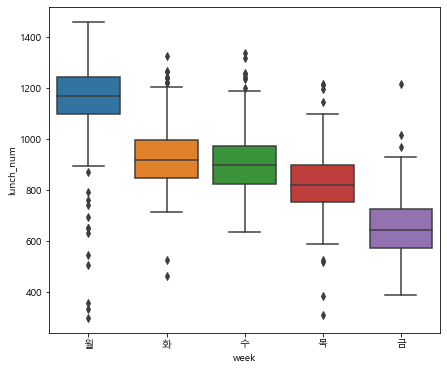

In [582]:
plt.figure(figsize=(7,6))
sns.boxplot(x="week", y='lunch_num', data=train)

In [583]:
train_mon = train.loc[train['week'] == '월']
train_tue = train.loc[train['week'] == '화']
train_wed = train.loc[train['week'] == '수']
train_thu = train.loc[train['week'] == '목']
train_fri = train.loc[train['week'] == '금']

In [584]:
week_df = [train_mon, train_tue, train_wed, train_thu, train_fri]
week_tx = ['train_mon', 'train_tue', 'train_wed', 'train_thu', 'train_fri']
print('=' * 40)
for i in range(5):
    print(week_tx[i])
    for j in range(5):
        _, pval = stats.levene(week_df[i]['lunch_num'], week_df[j]['lunch_num'])
        if pval > 0.05:
            _2, pval_t = ttest_ind(week_df[i]['lunch_num'], week_df[j]['lunch_num'], equal_var = True)
            print(pval_t,'    vs', week_tx[j])
        else :
            _2, pval_t = ttest_ind(week_df[i]['lunch_num'], week_df[j]['lunch_num'], equal_var = False)
            print(pval_t,'    vs', week_tx[j])
    print('=' * 40)

train_mon
1.0     vs train_mon
7.460344657903165e-47     vs train_tue
3.138241722033116e-46     vs train_wed
1.360769834405051e-82     vs train_thu
6.201291395979666e-139     vs train_fri
train_tue
7.460344657903165e-47     vs train_mon
1.0     vs train_tue
0.13853103300217712     vs train_wed
1.1689702494479013e-18     vs train_thu
8.540662591390006e-86     vs train_fri
train_wed
3.138241722033116e-46     vs train_mon
0.13853103300217712     vs train_tue
1.0     vs train_wed
4.7957244870189515e-12     vs train_thu
2.1986296403397977e-69     vs train_fri
train_thu
1.360769834405051e-82     vs train_mon
1.1689702494479013e-18     vs train_tue
4.7957244870189515e-12     vs train_wed
1.0     vs train_thu
1.5760907265634135e-41     vs train_fri
train_fri
6.201291395979666e-139     vs train_mon
8.540662591390006e-86     vs train_tue
2.1986296403397977e-69     vs train_wed
1.5760907265634135e-41     vs train_thu
1.0     vs train_fri


## **저녁 식수인원**

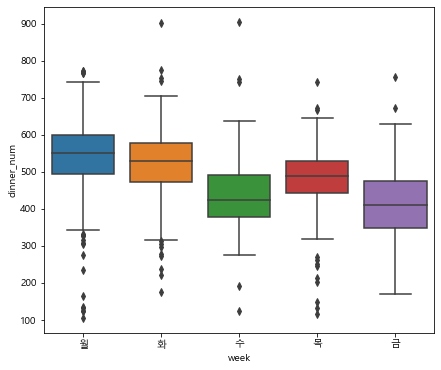

In [585]:
plt.figure(figsize=(7,6))
sns.boxplot(x="week", y='dinner_num', data=train)

In [586]:
week_df = [train_mon, train_tue, train_wed, train_thu, train_fri]
week_tx = ['train_mon', 'train_tue', 'train_wed', 'train_thu', 'train_fri']
print('=' * 40)
for i in range(5):
    print(week_tx[i])
    for j in range(5):
        _, pval = stats.levene(week_df[i]['dinner_num'], week_df[j]['dinner_num'])
        if pval > 0.05:
            _2, pval_t = ttest_ind(week_df[i]['dinner_num'], week_df[j]['dinner_num'], equal_var = True)
            print(pval_t,'    vs', week_tx[j])
        else :
            _2, pval_t = ttest_ind(week_df[i]['dinner_num'], week_df[j]['dinner_num'], equal_var = False)
            print(pval_t,'    vs', week_tx[j])
    print('=' * 40)

train_mon
1.0     vs train_mon
0.07854221031324399     vs train_tue
8.909818362151205e-23     vs train_wed
1.835465537685554e-10     vs train_thu
2.029104126138287e-36     vs train_fri
train_tue
0.07854221031324399     vs train_mon
1.0     vs train_tue
4.116724508931756e-19     vs train_wed
7.192441494033345e-07     vs train_thu
2.3025923660791158e-32     vs train_fri
train_wed
8.909818362151205e-23     vs train_mon
4.116724508931756e-19     vs train_tue
1.0     vs train_wed
5.175386943689183e-07     vs train_thu
0.002171886803901302     vs train_fri
train_thu
1.835465537685554e-10     vs train_mon
7.192441494033345e-07     vs train_tue
5.175386943689183e-07     vs train_wed
1.0     vs train_thu
1.774528396002984e-16     vs train_fri
train_fri
2.029104126138287e-36     vs train_mon
2.3025923660791158e-32     vs train_tue
0.002171886803901302     vs train_wed
1.774528396002984e-16     vs train_thu
1.0     vs train_fri


# ==============================  
# **가설4번 월초 월말에 식수인원이 차이가 있다**   
# **-완**

In [587]:
# 4번가설 train_4 copy
train_4 = train.copy()

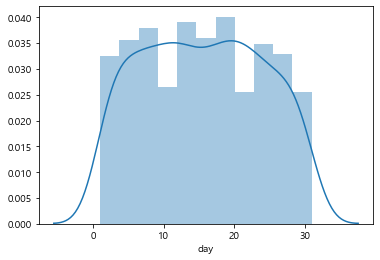

In [588]:
sns.distplot(train_4['day'])

In [589]:
train_4_begin = train_4[train_4['day'] < 11]
train_4_end = train_4[train_4['day'] > 20]

{'whiskers': [<matplotlib.lines.Line2D at 0x21b8b23df88>,
 'caps': [<matplotlib.lines.Line2D at 0x21b8b241f48>,
 'boxes': [<matplotlib.lines.Line2D at 0x21b8b23d688>,
 'medians': [<matplotlib.lines.Line2D at 0x21b8b246ec8>,
 'fliers': [<matplotlib.lines.Line2D at 0x21b8b246fc8>,
 'means': []}

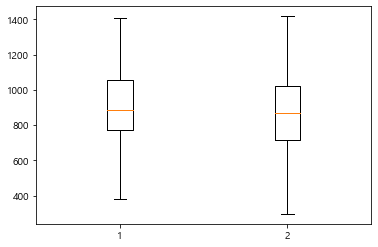

In [590]:
plt.boxplot([train_4_begin['lunch_num'], train_4_end['lunch_num']])

In [591]:
stats.levene(train_4_begin['lunch_num'],train_4_end['lunch_num'])

LeveneResult(statistic=0.5236346951320735, pvalue=0.4695206582156749)

In [592]:
ttest_ind(train_4_begin['lunch_num'],train_4_end['lunch_num'], equal_var=True)

Ttest_indResult(statistic=2.736749572466001, pvalue=0.006351613914409999)

#### **월초와 월말의 점심 식수인원이 유의미한 차이가 있다.**

{'whiskers': [<matplotlib.lines.Line2D at 0x21b8b2bdb48>,
 'caps': [<matplotlib.lines.Line2D at 0x21b8b2c1b08>,
 'boxes': [<matplotlib.lines.Line2D at 0x21b8b2bd288>,
 'medians': [<matplotlib.lines.Line2D at 0x21b8b2c6a88>,
 'fliers': [<matplotlib.lines.Line2D at 0x21b8b2c6b88>,
 'means': []}

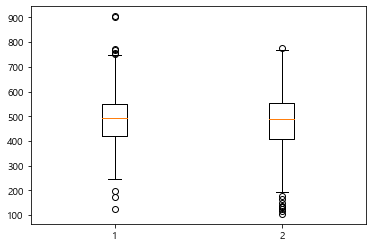

In [593]:
plt.boxplot([train_4_begin['dinner_num'], train_4_end['dinner_num']])

In [594]:
stats.levene(train_4_begin['dinner_num'],train_4_end['dinner_num'])

LeveneResult(statistic=1.7596856914435894, pvalue=0.185066958177375)

In [595]:
ttest_ind(train_4_begin['dinner_num'],train_4_end['dinner_num'], equal_var=True)

Ttest_indResult(statistic=1.4290620483740113, pvalue=0.1534022016862653)

#### **월초와 월말의 저녁 식수인원이 유의미한 차이가 없다.**

# ==========================  
# **가설5 월별로 식수인원에 차이가 있다**  
# **-완**

## **점심식수인원**

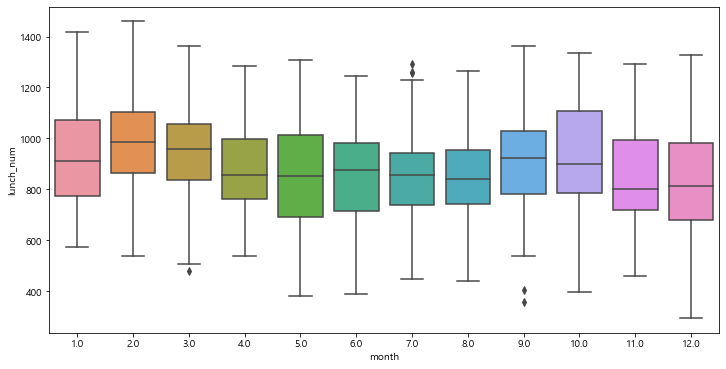

In [596]:
plt.figure(figsize=(12,6))
sns.boxplot(train['month'], train['lunch_num'])

In [597]:
month1 = train[train['month'] == 1]
month2 = train[train['month'] == 2]
month3 = train[train['month'] == 3]
month4 = train[train['month'] == 4]
month5 = train[train['month'] == 5]
month6 = train[train['month'] == 6]
month7 = train[train['month'] == 7]
month8 = train[train['month'] == 8]
month9 = train[train['month'] == 9]
month10 = train[train['month'] == 10]
month11 = train[train['month'] == 11]
month12 = train[train['month'] == 12]

In [598]:
month_df = [month1, month2, month3, month4, month5, month6, month7, month8, month9, month10, month11, month12]
month_tx = ['month1', 'month2', 'month3', 'month4', 'month5', 'month6', 'month7', 'month8', 'month9', 'month10', 'month11', 'month12']
print('=' * 40)
for i in range(12):
    print(month_tx[i])
    for j in range(12):
        _, pval = stats.levene(month_df[i]['lunch_num'], month_df[j]['lunch_num'])
        if pval > 0.05:
            _2, pval_t = ttest_ind(month_df[i]['lunch_num'], month_df[j]['lunch_num'], equal_var = True)
            print(pval_t,'    vs', month_tx[j])
        else :
            _2, pval_t = ttest_ind(month_df[i]['lunch_num'], month_df[j]['lunch_num'], equal_var = False)
            print(pval_t,'    vs', month_tx[j])
    print('=' * 40)

month1
1.0     vs month1
0.055160042665265786     vs month2
0.47595819900219327     vs month3
0.07170964050286478     vs month4
0.03716675071126511     vs month5
0.02484252242256189     vs month6
0.002954000509404556     vs month7
0.004185839691643352     vs month8
0.46454322528061665     vs month9
0.6593802887244702     vs month10
0.0015119495079699914     vs month11
0.002933229702667333     vs month12
month2
0.055160042665265786     vs month1
1.0     vs month2
0.2085837453986564     vs month3
0.00021945564274480887     vs month4
0.000156860760340326     vs month5
6.256001823213187e-05     vs month6
1.1404378269000349e-06     vs month7
2.2775201693687715e-06     vs month8
0.010145664309251125     vs month9
0.024011706082806474     vs month10
7.248574506150332e-07     vs month11
5.6773792369132105e-06     vs month12
month3
0.47595819900219327     vs month1
0.2085837453986564     vs month2
1.0     vs month3
0.010672957100093075     vs month4
0.005421066445636272     vs month5
0.00313399

## **저녁식수인원**

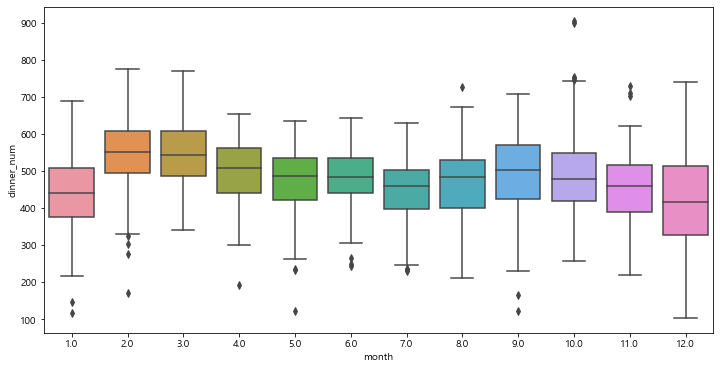

In [599]:
plt.figure(figsize=(12,6))
sns.boxplot(train['month'], train['dinner_num'])

In [600]:
month_df = [month1, month2, month3, month4, month5, month6, month7, month8, month9, month10, month11, month12]
month_tx = ['month1', 'month2', 'month3', 'month4', 'month5', 'month6', 'month7', 'month8', 'month9', 'month10', 'month11', 'month12']
print('=' * 40)
for i in range(12):
    print(month_tx[i])
    for j in range(12):
        _, pval = stats.levene(month_df[i]['dinner_num'], month_df[j]['dinner_num'])
        if pval > 0.05:
            _2, pval_t = ttest_ind(month_df[i]['dinner_num'], month_df[j]['dinner_num'], equal_var = True)
            print(pval_t,'    vs', month_tx[j])
        else :
            _2, pval_t = ttest_ind(month_df[i]['dinner_num'], month_df[j]['dinner_num'], equal_var = False)
            print(pval_t,'    vs', month_tx[j])
    print('=' * 40)

month1
1.0     vs month1
1.1601355654979663e-09     vs month2
9.521809222268265e-13     vs month3
0.00015283569576398425     vs month4
0.04106536896641942     vs month5
0.015518166857381681     vs month6
0.5735035771465381     vs month7
0.06829255288981938     vs month8
0.0033097614888716225     vs month9
0.00101890934629877     vs month10
0.36102221258564526     vs month11
0.16927152418714936     vs month12
month2
1.1601355654979663e-09     vs month1
1.0     vs month2
0.8949396619602626     vs month3
0.0009092470712318217     vs month4
7.5272630022323294e-06     vs month5
1.029509798716381e-05     vs month6
1.5659832597834804e-10     vs month7
1.0226909420743637e-06     vs month8
0.0014483033507391681     vs month9
0.009314647637376699     vs month10
2.4026567913569604e-08     vs month11
9.428019411575308e-11     vs month12
month3
9.521809222268265e-13     vs month1
0.8949396619602626     vs month2
1.0     vs month3
5.06114309716257e-05     vs month4
9.090194254037567e-08     vs month

# =================================  
# **가설6  코로나 전과 후에 식수 인원이 차이가 있다.**  
# **-완**

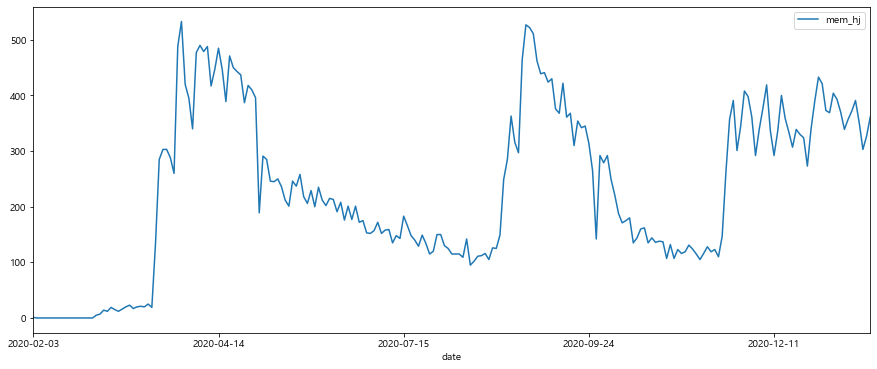

In [601]:
train[train['date'] > '2020-02-01'].plot('date', 'mem_hj', figsize = (15, 6))

In [602]:
train[train['date'] > '2020-02-25'][['date','mem_hj']].head(15)

,date,mem_hj
951,2020-02-27,5.0
952,2020-02-28,7.0
953,2020-03-02,14.0
954,2020-03-03,12.0
955,2020-03-04,19.0
956,2020-03-05,15.0
957,2020-03-06,12.0
958,2020-03-09,16.0
959,2020-03-10,20.0
960,2020-03-11,23.0


### **3월부터 재택근무자가 늘어남**  
### **신천지 코로나의 영향**

In [603]:
before_corona = train[train['date'] < '2020-03-01']
after_corona = train[train['date'] > '2020-03-01']

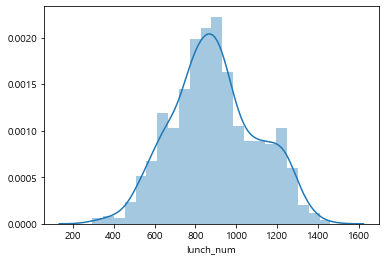

In [604]:
sns.distplot(before_corona['lunch_num'])

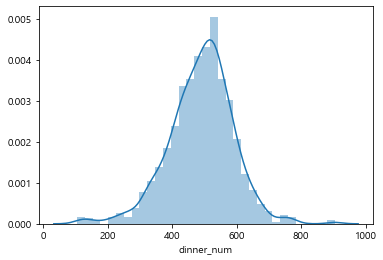

In [605]:
sns.distplot(before_corona['dinner_num'])

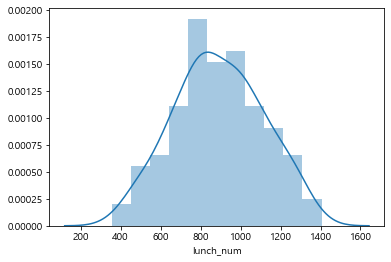

In [606]:
sns.distplot(after_corona['lunch_num'])

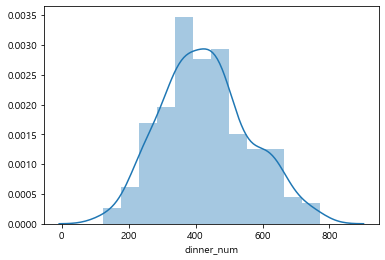

In [607]:
sns.distplot(after_corona['dinner_num'])

{'whiskers': [<matplotlib.lines.Line2D at 0x21b8ce3af48>,
 'caps': [<matplotlib.lines.Line2D at 0x21b8ce3ff08>,
 'boxes': [<matplotlib.lines.Line2D at 0x21b8ce3a608>,
 'medians': [<matplotlib.lines.Line2D at 0x21b8ce42e88>,
 'fliers': [<matplotlib.lines.Line2D at 0x21b8ce42f88>,
 'means': []}

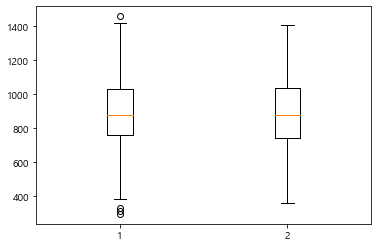

In [608]:
plt.boxplot([before_corona['lunch_num'], after_corona['lunch_num']])

In [609]:
stats.levene(before_corona['lunch_num'],after_corona['lunch_num'])

LeveneResult(statistic=2.7591851749040965, pvalue=0.09696793610002503)

In [610]:
ttest_ind(before_corona['lunch_num'], after_corona['lunch_num'], equal_var = True)

Ttest_indResult(statistic=0.11326785866140347, pvalue=0.9098378141122276)

#### **코로나 이전과 이후에 점심 식수인원은 유의미한 차이가 없다.**  

{'whiskers': [<matplotlib.lines.Line2D at 0x21b8d012f88>,
 'caps': [<matplotlib.lines.Line2D at 0x21b8d016fc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x21b8d012e08>,
 'medians': [<matplotlib.lines.Line2D at 0x21b8d01df48>,
 'fliers': [<matplotlib.lines.Line2D at 0x21b8d023dc8>,
 'means': []}

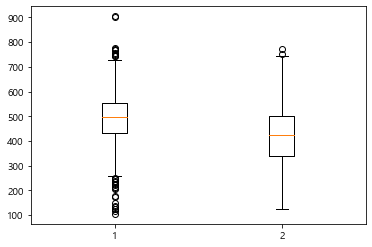

In [611]:
plt.boxplot([before_corona['dinner_num'], after_corona['dinner_num']])

In [612]:
stats.levene(before_corona['dinner_num'],after_corona['dinner_num'])

LeveneResult(statistic=29.343450212298645, pvalue=7.367230018667021e-08)

In [613]:
ttest_ind(before_corona['dinner_num'], after_corona['dinner_num'], equal_var = False)

Ttest_indResult(statistic=6.180649825321564, pvalue=2.4209321597273984e-09)

#### **코로나 이전과 이후에 저녁 식수인원은 유의미한 차이가 있다.**

# ===========================   
# **가설 7번  시간외 근무자가 많은날과 적은날에 석식계 차이가 있다.**  
# **-완**

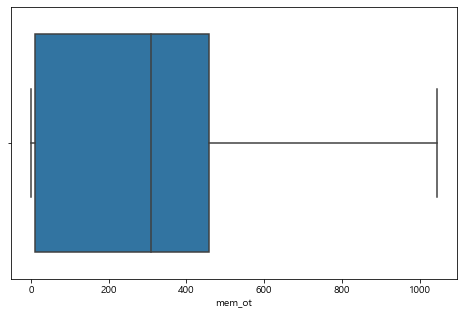

In [614]:
plt.figure(figsize=(8,5))
sns.boxplot(x = 'mem_ot', data = train)

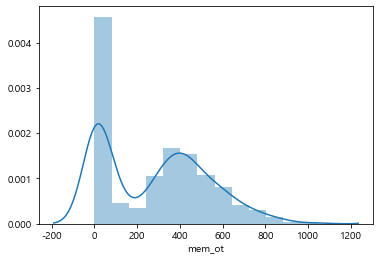

In [615]:
sns.distplot(train['mem_ot'])

In [616]:
train['mem_ot'].describe()

count    1161.000000
mean      284.371232
std       245.045800
min         0.000000
25%        11.000000
50%       310.000000
75%       458.000000
max      1044.000000
Name: mem_ot, dtype: float64

In [617]:
train_ot1 = train[train['mem_ot'] < 11]
train_ot2 = train[(train['mem_ot'] >= 11) & (train['mem_ot'] < 310)]
train_ot3 = train[(train['mem_ot'] >= 310) & (train['mem_ot'] < 458)]
train_ot4 = train[train['mem_ot'] >= 458]

[Text(0, 0, 'mem_ot < 11\ngroup1'),
 Text(0, 0, '11 <= mem_ot < 310\ngroup2'),
 Text(0, 0, '310 <= mem_ot < 458\ngroup3'),
 Text(0, 0, '458 <= mem_ot\ngroup4')]

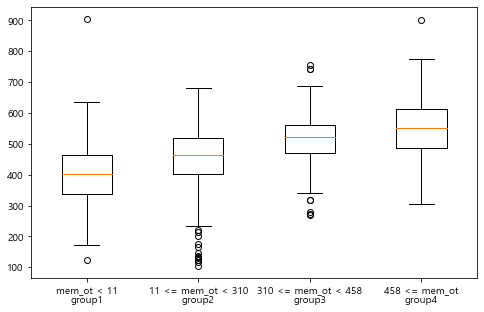

In [618]:
fig5, ax5 = plt.subplots(nrows = 1, ncols = 1 , figsize = (8,5))
ax5.boxplot([train_ot1['dinner_num'], train_ot2['dinner_num'], train_ot3['dinner_num'], train_ot4['dinner_num']])
ax5.set_xticklabels(['mem_ot < 11\ngroup1', '11 <= mem_ot < 310\ngroup2', '310 <= mem_ot < 458\ngroup3', '458 <= mem_ot\ngroup4'])

In [619]:
# 7번가설 train_7 copy
train_7 = train.copy()

In [620]:
# 분위수를 기준으로 그룹 나누기
train_7['mem_ot_g'] = pd.cut(train_7['mem_ot'], bins = [-1, 11, 310, 458, 1045], labels = [0,1,2,3])

In [621]:
train_7['mem_ot_g']

0       1
1       2
2       1
3       2
4       1
       ..
1156    0
1157    3
1158    0
1159    3
1160    3
Name: mem_ot_g, Length: 1161, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]

In [622]:
spp = train_7.loc[:,['dinner_num','mem_ot_g']]

In [623]:
# 확인
spp.groupby('mem_ot_g').count()

,dinner_num
mem_ot_g,
0,291
1,291
2,289
3,290


In [624]:
sp = np.array(spp)
group1 = sp[sp[: ,1] == 0,0]
group2 = sp[sp[: ,1] == 1,0]
group3 = sp[sp[: ,1] == 2,0]
group4 = sp[sp[: ,1] == 3,0]

In [625]:
plot_sp = [group1, group2, group3, group4]

[Text(0, 0, 'mem_ot < 11'),
 Text(0, 0, '11 <= mem_ot < 310'),
 Text(0, 0, '310 <= mem_ot < 458'),
 Text(0, 0, '458 <= mem_ot')]

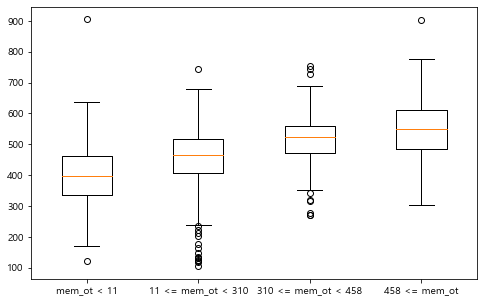

In [626]:
fig5, ax5 = plt.subplots(nrows = 1, ncols = 1 , figsize = (8,5))
ax5.boxplot(plot_sp)
ax5.set_xticklabels(['mem_ot < 11', '11 <= mem_ot < 310', '310 <= mem_ot < 458', '458 <= mem_ot'])

In [627]:
_, pval = stats.f_oneway(group1, group2, group3, group4)

pval

4.4141962787881275e-84

In [628]:
stats.kruskal(group1, group2, group3, group4)

KruskalResult(statistic=358.60321509746495, pvalue=2.045287872172684e-77)

In [629]:
a = [group1, group2, group3, group4]
b = ['group1','group2','group3','group4']
print('=' * 40)
for i in range(4):
    print(b[i])
    for j in range(4):
        _, pval = stats.levene(a[i], a[j])
        if pval > 0.05:
            _2, pval_t = ttest_ind(a[i], a[j], equal_var = True)
            print(pval_t,'    vs', b[j])
        else :
            _2, pval_t = ttest_ind(a[i], a[j], equal_var = False)
            print(pval_t,'    vs', b[j])
    print('=' * 40)

group1
1.0     vs group1
9.78058113341322e-11     vs group2
2.2137106993412654e-50     vs group3
3.41521999161864e-64     vs group4
group2
9.78058113341322e-11     vs group1
1.0     vs group2
2.6219817819803154e-16     vs group3
3.6537336819460045e-29     vs group4
group3
2.2137106993412654e-50     vs group1
2.6219817819803154e-16     vs group2
1.0     vs group3
1.2537514764110131e-06     vs group4
group4
3.41521999161864e-64     vs group1
3.6537336819460045e-29     vs group2
1.2537514764110131e-06     vs group3
1.0     vs group4


# **가설검정 끝**
# =====================================================  
# **모델링**

In [630]:
train.columns

Index(['date', 'week', 'mem_tot', 'mem_va', 'mem_bt', 'mem_ot', 'mem_hj',
       'lunch_num', 'dinner_num', 'lunch_tem', 'lunch_rain', 'dinner_tem',
       'dinner_rain', 'mem_poss', 'month', 'day', 'holi_be', 'holi_af',
       'summer1', 'year_end'],
      dtype='object')

In [631]:
feature = ['month','day','week','mem_poss','mem_ot','mem_hj','lunch_tem','lunch_rain',
           'dinner_tem','dinner_rain','holi_be','holi_af','summer1','year_end']

In [632]:
target = ['lunch_num','dinner_num']

In [633]:
train_model = train[feature+target]

In [634]:
train_model

,month,day,week,mem_poss,mem_ot,mem_hj,lunch_tem,lunch_rain,dinner_tem,dinner_rain,holi_be,holi_af,summer1,year_end,lunch_num,dinner_num
0,2.0,1.0,월,2401.0,238.0,0.0,3.0,0.0,0.9,0.0,0.0,1.0,0.0,0.0,1039.0,331.0
1,2.0,2.0,화,2378.0,319.0,0.0,1.7,0.0,2.4,0.0,0.0,0.0,0.0,0.0,867.0,560.0
2,2.0,3.0,수,2365.0,111.0,0.0,3.2,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1017.0,573.0
3,2.0,4.0,목,2277.0,355.0,0.0,3.7,0.0,4.0,0.0,0.0,0.0,0.0,0.0,978.0,525.0
4,2.0,5.0,금,2142.0,34.0,0.0,6.3,0.0,5.7,0.0,1.0,0.0,0.0,0.0,925.0,330.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,1.0,20.0,수,2319.0,4.0,391.0,4.8,0.0,6.7,0.0,0.0,0.0,0.0,0.0,1093.0,421.0
1157,1.0,21.0,목,2309.0,462.0,351.0,9.1,0.0,9.6,0.0,0.0,0.0,0.0,0.0,832.0,353.0
1158,1.0,22.0,금,2177.0,1.0,303.0,8.4,0.0,8.0,0.0,1.0,0.0,0.0,0.0,579.0,217.0
1159,1.0,25.0,월,2396.0,616.0,327.0,11.3,0.0,10.2,0.0,0.0,1.0,0.0,0.0,1145.0,502.0


In [635]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [636]:
x_l = train_model[['month', 'day', 'mem_poss', 'mem_ot', 'lunch_tem','lunch_rain',
                   'holi_be','holi_af','summer1','year_end']]
y_l = train_model['lunch_num']

x_d = train_model[['month', 'day', 'mem_poss', 'mem_ot', 'dinner_tem','dinner_rain',
                   'holi_be','holi_af','summer1','year_end']]
y_d = train_model['dinner_num']

In [637]:
x_l_train, x_l_test, y_l_train, y_l_test = train_test_split(x_l, y_l, test_size=0.3, shuffle=True, random_state=1004)
x_d_train, x_d_test, y_d_train, y_d_test = train_test_split(x_d, y_d, test_size=0.3, shuffle=True, random_state=1004)

### **코로나 이전**

In [638]:
bc_model = before_corona[feature+target]

In [639]:
x_bc_l = bc_model[['month', 'day', 'mem_poss', 'mem_ot', 'lunch_tem','lunch_rain','holi_be','holi_af','summer1','year_end']]
y_bc_l = bc_model['lunch_num']
x_bc_d = bc_model[['month', 'day', 'mem_poss', 'mem_ot', 'dinner_tem','dinner_rain','holi_be','holi_af','summer1','year_end']]
y_bc_d = bc_model['dinner_num']

In [640]:
x_bc_l_train, x_bc_l_test, y_bc_l_train, y_bc_l_test = train_test_split(x_bc_l, y_bc_l, test_size=0.3, shuffle=True, random_state=1004)
x_bc_d_train, x_bc_d_test, y_bc_d_train, y_bc_d_test = train_test_split(x_bc_d, y_bc_d, test_size=0.3, shuffle=True, random_state=1004)

### **코로나 이후**

In [641]:
ac_model = after_corona[feature+target]

In [642]:
x_ac_l = ac_model[['month', 'day', 'mem_poss', 'mem_ot', 'lunch_tem','lunch_rain','holi_be','holi_af','summer1','year_end']]
y_ac_l = ac_model['lunch_num']
x_ac_d = ac_model[['month', 'day', 'mem_poss', 'mem_ot', 'dinner_tem','dinner_rain','holi_be','holi_af','summer1','year_end']]
y_ac_d = ac_model['dinner_num']

In [643]:
x_ac_l_train, x_ac_l_test, y_ac_l_train, y_ac_l_test = train_test_split(x_ac_l, y_ac_l, test_size=0.3, shuffle=True, random_state=1004)
x_ac_d_train, x_ac_d_test, y_ac_d_train, y_ac_d_test = train_test_split(x_ac_d, y_ac_d, test_size=0.3, shuffle=True, random_state=1004)

# **RandomForestRegressor**

In [644]:
from sklearn.ensemble import RandomForestRegressor
rf_l = RandomForestRegressor()
rf_l.fit(x_l_train, y_l_train)
rf_l.score(x_l_test, y_l_test)

0.7112773457371271

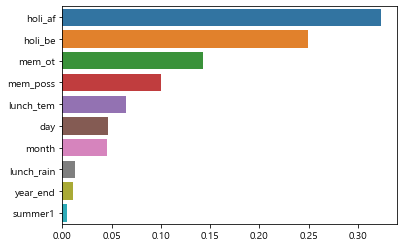

In [645]:
ft_importance_values = rf_l.feature_importances_
ft_series = pd.Series(ft_importance_values, index = x_l.columns)
ft_top = ft_series.sort_values(ascending=False)
plt.figure()
g = sns.barplot(x = ft_top, y = ft_top.index)
g
plt.show()

In [646]:
rf_d = RandomForestRegressor()
rf_d.fit(x_d_train, y_d_train)
rf_d.score(x_d_test, y_d_test)

0.4974296282994087

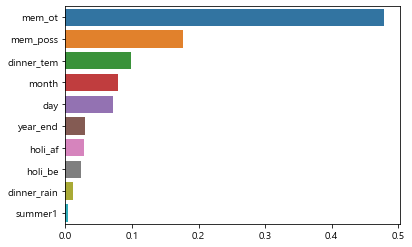

In [647]:
ft_importance_values = rf_d.feature_importances_
ft_series = pd.Series(ft_importance_values, index = x_d.columns)
ft_top = ft_series.sort_values(ascending=False)
plt.figure()
g = sns.barplot(x = ft_top, y = ft_top.index)
g
plt.show()

# =======================================  
## **코로나 이전**

In [648]:
rf_bc_l = RandomForestRegressor()
rf_bc_l.fit(x_bc_l_train, y_bc_l_train)
rf_bc_l.score(x_bc_l_test, y_bc_l_test)

0.7515622568548376

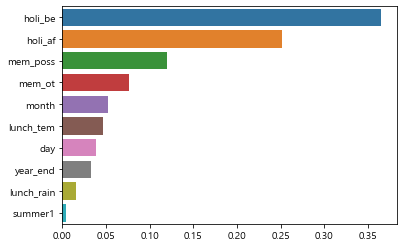

In [649]:
ft_importance_values = rf_bc_l.feature_importances_
ft_series = pd.Series(ft_importance_values, index = x_bc_l.columns)
ft_top = ft_series.sort_values(ascending=False)
plt.figure()
g = sns.barplot(x = ft_top, y = ft_top.index)
g
plt.show()

In [650]:
rf_bc_d = RandomForestRegressor()
rf_bc_d.fit(x_bc_d_train, y_bc_d_train)
rf_bc_d.score(x_bc_d_test, y_bc_d_test)

0.45734740135342306

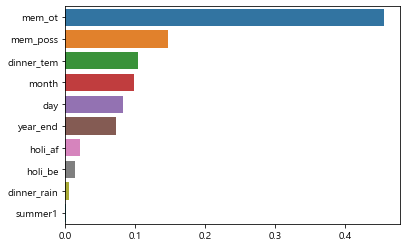

In [651]:
ft_importance_values = rf_bc_d.feature_importances_
ft_series = pd.Series(ft_importance_values, index = x_bc_d.columns)
ft_top = ft_series.sort_values(ascending=False)
plt.figure()
g = sns.barplot(x = ft_top, y = ft_top.index)
g
plt.show()

# =======================================  
## **코로나 이후**

In [652]:
rf_ac_l = RandomForestRegressor()
rf_ac_l.fit(x_ac_l_train, y_ac_l_train)
rf_ac_l.score(x_ac_l_test, y_ac_l_test)

0.4544520882850585

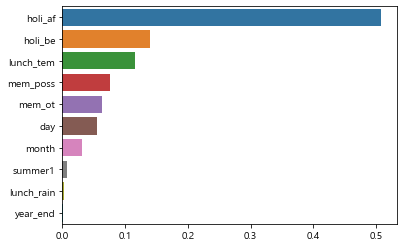

In [653]:
ft_importance_values = rf_ac_l.feature_importances_
ft_series = pd.Series(ft_importance_values, index = x_ac_l.columns)
ft_top = ft_series.sort_values(ascending=False)
plt.figure()
g = sns.barplot(x = ft_top, y = ft_top.index)
g
plt.show()

In [654]:
rf_ac_d = RandomForestRegressor()
rf_ac_d.fit(x_ac_d_train, y_ac_d_train)
rf_ac_d.score(x_ac_d_test, y_ac_d_test)

0.7793960766932063

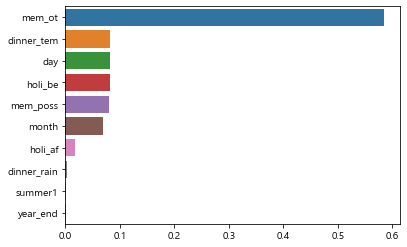

In [655]:
ft_importance_values = rf_ac_d.feature_importances_
ft_series = pd.Series(ft_importance_values, index = x_ac_d.columns)
ft_top = ft_series.sort_values(ascending=False)
plt.figure()
g = sns.barplot(x = ft_top, y = ft_top.index)
g
plt.show()

# =========================================

# **XGBoost**

In [656]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import RobustScaler

In [657]:
xg_l = XGBRegressor() 
xg_l.fit(x_l_train, y_l_train)

[16:17:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

점심 식수인원 예측 score :  0.7447773997576094


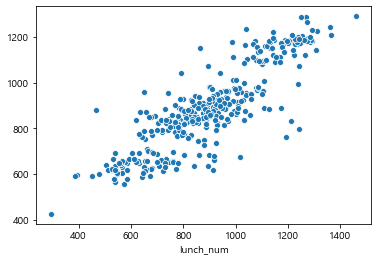

In [658]:
sns.scatterplot(y_l_test, xg_l.predict(x_l_test))
print('점심 식수인원 예측 score : ',xg_l.score(x_l_test, y_l_test))

In [659]:
xg_d = XGBRegressor() 
xg_d.fit(x_d_train, y_d_train)

[16:17:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

저녁 식수인원 예측 score :  0.5462858717622264


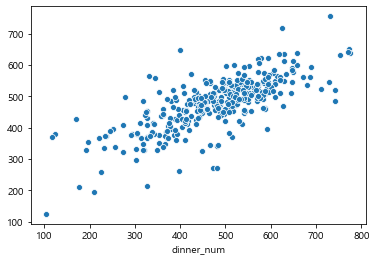

In [660]:
sns.scatterplot(y_d_test, xg_d.predict(x_d_test))
print('저녁 식수인원 예측 score : ',xg_d.score(x_d_test, y_d_test))

## **코로나 이전**

In [661]:
xg_bc_l = XGBRegressor() 
xg_bc_l.fit(x_bc_l_train, y_bc_l_train)

[16:17:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

코로나 이전 점심 식수인원 예측 score :  0.7545933443756944


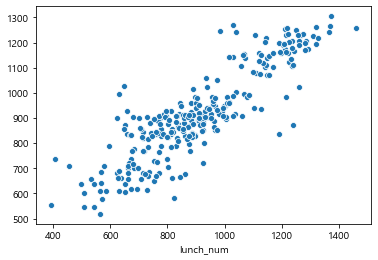

In [662]:
sns.scatterplot(y_bc_l_test, xg_bc_l.predict(x_bc_l_test))
print('코로나 이전 점심 식수인원 예측 score : ',xg_bc_l.score(x_bc_l_test, y_bc_l_test))

In [663]:
xg_bc_d = XGBRegressor()
xg_bc_d.fit(x_bc_d_train, y_bc_d_train)

[16:17:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

코로나 이전 저녁 식수인원 예측 score :  0.5509644717971985


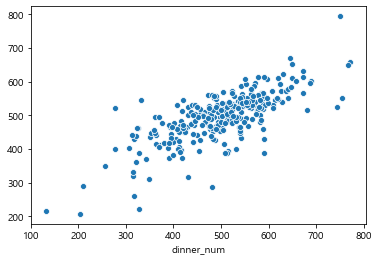

In [664]:
sns.scatterplot(y_bc_d_test, xg_bc_d.predict(x_bc_d_test))
print('코로나 이전 저녁 식수인원 예측 score : ',xg_bc_d.score(x_bc_d_test, y_bc_d_test))

## **코로나 이후**

In [665]:
xg_ac_l = XGBRegressor()
xg_ac_l.fit(x_ac_l_train, y_ac_l_train)

[16:17:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

코로나 이후 점심 식수인원 예측 score :  0.5740874145466672


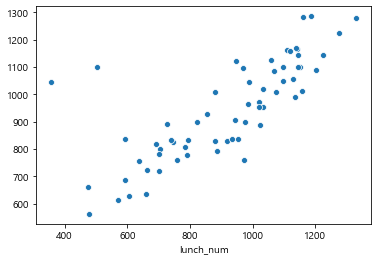

In [666]:
sns.scatterplot(y_ac_l_test, xg_ac_l.predict(x_ac_l_test))
print('코로나 이후 점심 식수인원 예측 score : ',xg_ac_l.score(x_ac_l_test, y_ac_l_test))

In [667]:
xg_ac_d = XGBRegressor()
xg_ac_d.fit(x_ac_d_train, y_ac_d_train)

[16:17:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

코로나 이후 저녁 식수인원 예측 score :  0.7557081191168687


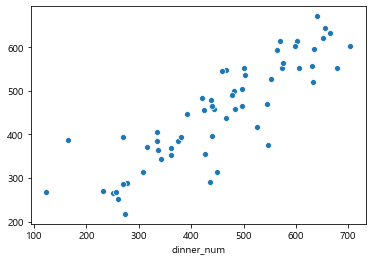

In [668]:
sns.scatterplot(y_ac_d_test, xg_ac_d.predict(x_ac_d_test))
print('코로나 이후 저녁 식수인원 예측 score : ',xg_ac_d.score(x_ac_d_test, y_ac_d_test))

# =========================================

# **LGBM**

In [669]:
import lightgbm as lgb

In [670]:
lg_l = lgb.LGBMRegressor()
lg_l.fit(x_l_train, y_l_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

점심 식수인원 예측 score :  0.7202868530727615


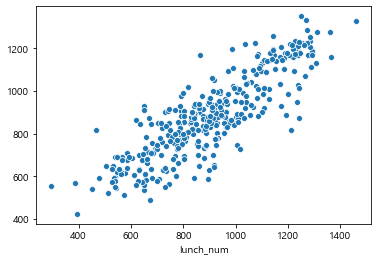

In [671]:
sns.scatterplot(y_l_test, lg_l.predict(x_l_test))
print('점심 식수인원 예측 score : ',lg_l.score(x_l_test, y_l_test))

In [672]:
lg_d = lgb.LGBMRegressor()
lg_d.fit(x_d_train, y_d_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

저녁 식수인원 예측 score :  0.5187265861971204


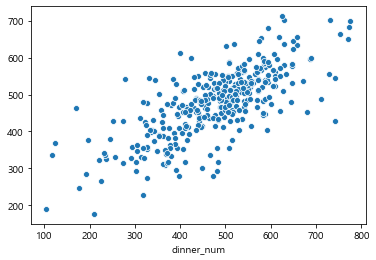

In [673]:
sns.scatterplot(y_d_test, lg_d.predict(x_d_test))
print('저녁 식수인원 예측 score : ',lg_d.score(x_d_test, y_d_test))

## **코로나 이전**

In [674]:
lg_bc_l = lgb.LGBMRegressor()
lg_bc_l.fit(x_bc_l_train, y_bc_l_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

코로나 이전 점심 식수인원 예측 score :  0.7530076395271359


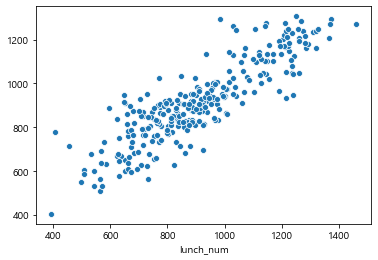

In [675]:
sns.scatterplot(y_bc_l_test, lg_bc_l.predict(x_bc_l_test))
print('코로나 이전 점심 식수인원 예측 score : ',lg_bc_l.score(x_bc_l_test, y_bc_l_test))

In [676]:
lg_bc_d = lgb.LGBMRegressor()
lg_bc_d.fit(x_bc_d_train, y_bc_d_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

코로나 이전 저녁 식수인원 예측 score :  0.5271551532704286


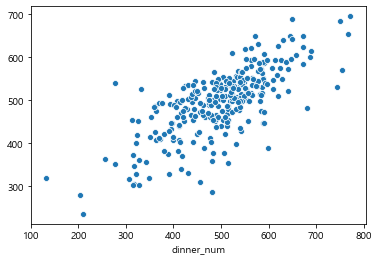

In [677]:
sns.scatterplot(y_bc_d_test, lg_bc_d.predict(x_bc_d_test))
print('코로나 이전 저녁 식수인원 예측 score : ',lg_bc_d.score(x_bc_d_test, y_bc_d_test))

## **코로나 이후**

In [678]:
lg_ac_l = lgb.LGBMRegressor()
lg_ac_l.fit(x_ac_l_train, y_ac_l_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

코로나 이후 점심 식수인원 예측 score :  0.5595293746116121


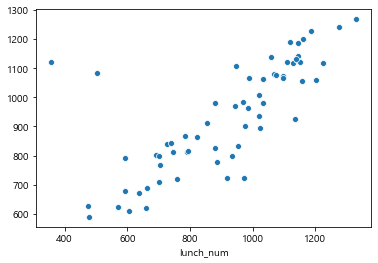

In [679]:
sns.scatterplot(y_ac_l_test, lg_ac_l.predict(x_ac_l_test))
print('코로나 이후 점심 식수인원 예측 score : ',lg_ac_l.score(x_ac_l_test, y_ac_l_test))

In [680]:
lg_ac_d = lgb.LGBMRegressor()
lg_ac_d.fit(x_ac_d_train, y_ac_d_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

코로나 이후 저녁 식수인원 예측 score :  0.69770460752862


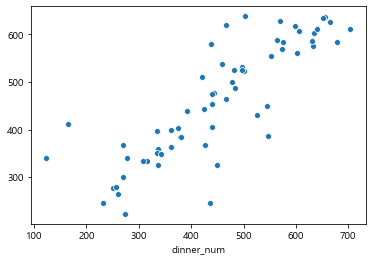

In [681]:
sns.scatterplot(y_ac_d_test, lg_ac_d.predict(x_ac_d_test))
print('코로나 이후 저녁 식수인원 예측 score : ',lg_ac_d.score(x_ac_d_test, y_ac_d_test))

# ===============================================

# **모델 비교**

In [682]:
score = pd.DataFrame(columns = ['group','score','model'])

In [683]:
score.loc[0] = ['lunch',rf_l.score(x_l_test, y_l_test), 'RandomForest']
score.loc[1] = ['dinner',rf_d.score(x_d_test, y_d_test), 'RandomForest']
score.loc[2] = ['b_corona_lunch',rf_bc_l.score(x_bc_l_test, y_bc_l_test), 'RandomForest']
score.loc[3] = ['b_corona_dinner',rf_bc_d.score(x_bc_d_test, y_bc_d_test), 'RandomForest']
score.loc[4] = ['a_corona_lunch',rf_ac_l.score(x_ac_l_test, y_ac_l_test), 'RandomForest']
score.loc[5] = ['a_corona_dinner',rf_ac_d.score(x_ac_d_test, y_ac_d_test), 'RandomForest']
score.loc[6] = ['lunch',xg_l.score(x_l_test, y_l_test), 'XGBoost']
score.loc[7] = ['dinner',xg_d.score(x_d_test, y_d_test), 'XGBoost']
score.loc[8] = ['b_corona_lunch',xg_bc_l.score(x_bc_l_test, y_bc_l_test), 'XGBoost']
score.loc[9] = ['b_corona_dinner',xg_bc_d.score(x_bc_d_test, y_bc_d_test), 'XGBoost']
score.loc[10] = ['a_corona_lunch',xg_ac_l.score(x_ac_l_test, y_ac_l_test), 'XGBoost']
score.loc[11] = ['a_corona_dinner',xg_ac_d.score(x_ac_d_test, y_ac_d_test), 'XGBoost']
score.loc[12] = ['lunch',lg_l.score(x_l_test, y_l_test), 'LGBM']
score.loc[13] = ['dinner',lg_d.score(x_d_test, y_d_test), 'LGBM']
score.loc[14] = ['b_corona_lunch',lg_bc_l.score(x_bc_l_test, y_bc_l_test), 'LGBM']
score.loc[15] = ['b_corona_dinner',lg_bc_d.score(x_bc_d_test, y_bc_d_test), 'LGBM']
score.loc[16] = ['a_corona_lunch',lg_ac_l.score(x_ac_l_test, y_ac_l_test), 'LGBM']
score.loc[17] = ['a_corona_dinner',lg_ac_d.score(x_ac_d_test, y_ac_d_test), 'LGBM']

In [684]:
score

,group,score,model
0,lunch,0.711277,RandomForest
1,dinner,0.497430,RandomForest
2,b_corona_lunch,0.751562,RandomForest
3,b_corona_dinner,0.457347,RandomForest
4,a_corona_lunch,0.454452,RandomForest
5,a_corona_dinner,0.779396,RandomForest
6,lunch,0.744777,XGBoost
7,dinner,0.546286,XGBoost
8,b_corona_lunch,0.754593,XGBoost
9,b_corona_dinner,0.550964,XGBoost


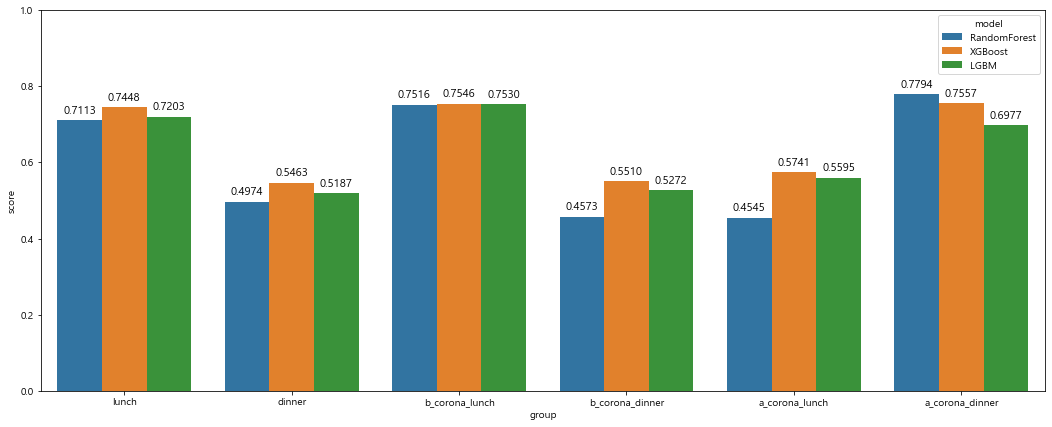

In [685]:
fig = plt.figure(figsize = (18,7))
plt.axis([0, 0,0, 1])
x_axis = score['group']
y_axis = score['score']
g=sns.barplot(x_axis, y_axis, hue = score['model'])
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
                ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                    textcoords='offset points')


In [686]:
train.to_csv('final.csv')